
# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [5]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d

import torch

torch.set_grad_enabled(False)
from pathlib import Path

images = Path("lung-lobes_1/scale-5pc")

## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [3]:
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import pandas as pd
import os
base_dir = '/home/20223176/LightGlue/'
image_paths = []

# 디렉토리 순회
for root, dirs, files in os.walk(base_dir):
    for subdir in dirs:
        scale_dir = os.path.join(root, subdir)
        png_files = [f for f in os.listdir(scale_dir) if f.endswith(".png")]

        # 이미지 경로 추가
        for png_file in png_files:
            image_paths.append(os.path.join(scale_dir, png_file))

# 기존 image_paths 기반으로 추가 경로 생성
new_image_paths = []
scales = ["scale-50pc", "scale-25pc", "scale-10pc", "scale-5pc"]

for path in image_paths:
    if "scale-100pc" in path:
        # 다른 스케일 경로 생성
        for scale in scales:
            new_path = path.replace("scale-50pc", scale)
            new_image_paths.append(new_path)

# 모든 경로 합치기
all_image_paths = image_paths + new_image_paths


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=1024).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

A unified method to revoke the private data
of patients in intelligent healthcare with
audit to forget## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

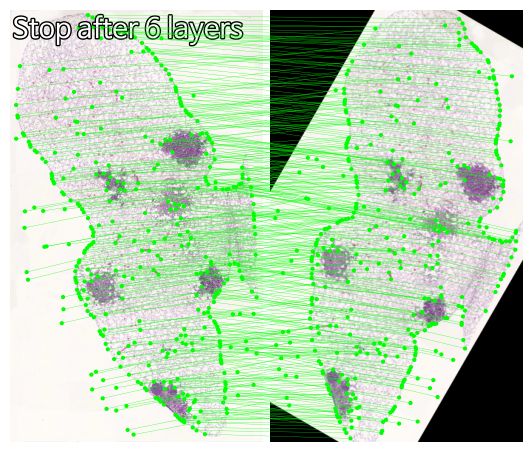

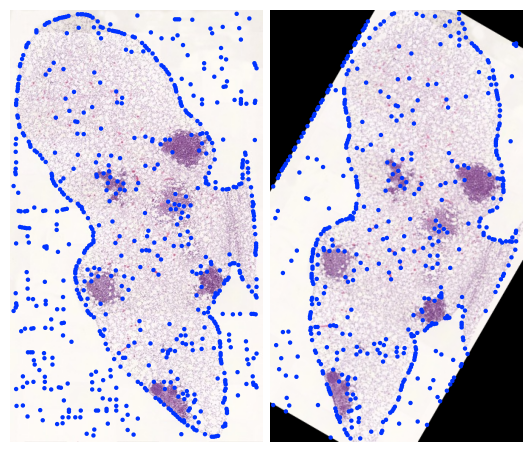

In [7]:
import numpy as np
import cv2
image0 = load_image(images / "29-039-U-35W-Izd1-1-HE.jpg")
if image0.is_cuda:
    image0 = image0.cpu()
image0_np = image0.numpy()

# (C, H, W) -> (H, W, C)
image0_np = np.transpose(image0_np, (1, 2, 0))

# OpenCV로 회전
(h, w) = image0_np.shape[:2]
center = (w / 2, h / 2)
angle = -30
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image_np = cv2.warpAffine(image0_np, M, (w, h))

# (H, W, C) -> (C, H, W)
rotated_image_np = np.transpose(rotated_image_np, (2, 0, 1))

# NumPy -> Tensor 변환
image1 = torch.from_numpy(rotated_image_np).float()  # float 타입으로 변환
image0 = torch.from_numpy(image0_np.transpose(2, 0, 1)).float()

# GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# image1 = load_image(images / "29-039-U-35W-Izd1-6-ki67.jpg")
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
# viz2d.save_plot(images"./output/keypoints_matching.png", dpi=300)
kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
# viz2d.save_plot("./output/outkeypoints_visualization.png", dpi=300)

In [6]:
import torch
import torchvision.transforms as T
import numpy as np
import pandas as pd
import random
import torchvision.transforms.functional as F
from PIL import Image

def augment_image_with_matrix(image, angle_range=(-30, 30), seed=None):
    if seed is not None:
        random.seed(seed)
    angle = random.uniform(*angle_range)
    
    radians = np.radians(-angle)  
    cos_theta, sin_theta = np.cos(radians), np.sin(radians)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
    
    if isinstance(image, torch.Tensor):
        h, w = image.shape[1:]  
    else:
        w, h = image.size  
    
    center = np.array([w / 2, h / 2])
    translation = center - np.dot(rotation_matrix, center)
    
    transform_matrix = np.eye(3)
    transform_matrix[:2, :2] = rotation_matrix
    transform_matrix[:2, 2] = translation

    if isinstance(image, torch.Tensor):
        image = F.to_pil_image(image)
    
    rotated_image = F.rotate(image, angle)
    
    rotated_image = T.ToTensor()(rotated_image)
    
    return rotated_image, transform_matrix



def inverse_transform(points, transform_matrix):    
    ones = np.ones((points.shape[0], 1)) 
    points_homogeneous = np.hstack([points, ones])  
    
    inv_matrix = np.linalg.inv(transform_matrix)
    
    original_points_homogeneous = np.dot(points_homogeneous, inv_matrix.T)
    
    original_points = original_points_homogeneous[:, :2] 
    return original_points





In [21]:
import matplotlib.pyplot as plt
import os
from PIL import Image

results_folder = "results"
augmented_images_folder = "augmented_images"
os.makedirs(results_folder, exist_ok=True)
os.makedirs(augmented_images_folder, exist_ok=True)

num_augmentations = 100

results = []
image0 = load_image(images / "29-039-U-35W-Izd1-1-HE.jpg")

if image0.max() > 1:
    image0 = image0 / 255.0

feats0 = extractor.extract(image0.to(device))
feats0_copy = rbd(feats0)  
kpts0 = feats0_copy["keypoints"].cpu().numpy()  

image0_np = image0.permute(1, 2, 0).cpu().numpy()
image0_np = (image0_np * 255).astype(np.uint8)  

for i in range(num_augmentations):
    seed = i
    image1, transform_matrix = augment_image_with_matrix(image0, seed=seed)
    image1 = image1.to(device)

    image1_np = image1.permute(1, 2, 0).cpu().numpy()
    image1_np = (image1_np * 255).astype(np.uint8)  
    image1_pil = Image.fromarray(image1_np) 
    image1_path = os.path.join(augmented_images_folder, f"{seed}.jpg")
    image1_pil.save(image1_path) 
    
    feats1 = extractor.extract(image1)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats1 = rbd(feats1)
    matches01 = rbd(matches01)

    kpts1 = feats1["keypoints"]
    matches = matches01["matches"]
    matches = torch.tensor(matches, dtype=torch.long) if isinstance(matches, list) else matches

    if matches.shape[0] == 0:
        print(f"No matches found for seed {seed}. Skipping...")
        continue

    m_kpts0 = kpts0[matches.cpu().numpy()[:, 0]]  
    m_kpts1 = kpts1[matches.cpu().numpy()[:, 1]].cpu().numpy()  
    recovered_points = inverse_transform(m_kpts1, transform_matrix)
    
    for pt0, pt1, rec_pt in zip(m_kpts0, m_kpts1, recovered_points):
        results.append({
            "image0_x": pt0[0], "image0_y": pt0[1], 
            "image1_x": pt1[0], "image1_y": pt1[1], 
            "recovered_x": rec_pt[0], "recovered_y": rec_pt[1],
            "seed": seed  
        })

    plt.figure(figsize=(10, 10))
    plt.imshow(image0_np, cmap="gray")
    plt.scatter(m_kpts0[:, 0], m_kpts0[:, 1], c="blue", label="Image0 Points", s=15)
    plt.scatter(recovered_points[:, 0], recovered_points[:, 1], c="red", label="Recovered Points", s=15, alpha=0.7)
    plt.legend()
    plt.title(f"Seed {seed} - Restored Points")
    plt.axis("off")

    output_path = os.path.join(results_folder, f"restored_seed_{seed}.png")
    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.close()



In [51]:
num_augmentations = 100

results = []
image0 = load_image(images / "29-039-U-35W-Izd1-1-HE.jpg")

if image0.max() > 1:
    image0 = image0 / 255.0

feats0 = extractor.extract(image0.to(device))
feats0_copy = rbd(feats0)  
kpts0 = feats0_copy["keypoints"].cpu().numpy()  

for i in range(num_augmentations):
    seed = i
    image1, transform_matrix = augment_image_with_matrix(image0, seed=seed)
    image1 = image1.to(device)

    feats1 = extractor.extract(image1)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats1 = rbd(feats1)
    matches01 = rbd(matches01)

    kpts1 = feats1["keypoints"]
    matches = matches01["matches"]
    matches = torch.tensor(matches, dtype=torch.long) if isinstance(matches, list) else matches

    if matches.shape[0] == 0:
        print(f"No matches found for seed {seed}. Skipping...")
        continue

    m_kpts0 = kpts0[matches.cpu().numpy()[:, 0]]  
    m_kpts1 = kpts1[matches.cpu().numpy()[:, 1]].cpu().numpy()
    recovered_points = inverse_transform(m_kpts1, transform_matrix)

    for pt0, pt1, rec_pt in zip(m_kpts0, m_kpts1, recovered_points):
        results.append({
            "image0_x": pt0[0], "image0_y": pt0[1],
            "image1_x": pt1[0], "image1_y": pt1[1],
            "recovered_x": rec_pt[0], "recovered_y": rec_pt[1],
            "seed": seed  
        })

df = pd.DataFrame(results)
df.to_csv("matched_coordinates_fixed_image0.csv", index=False)



In [11]:
from collections import defaultdict

results = []
image0_matches = defaultdict(list)
image0 = load_image(images / "29-039-U-35W-Izd1-1-HE.jpg")

if image0.max() > 1:
    image0 = image0 / 255.0

feats0 = extractor.extract(image0.to(device))
feats0_copy = rbd(feats0)
kpts0 = feats0_copy["keypoints"].cpu().numpy()  

for i in range(num_augmentations):
    seed = i
    image1, transform_matrix = augment_image_with_matrix(image0, seed=seed)
    image1 = image1.to(device)

    feats1 = extractor.extract(image1)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats1 = rbd(feats1)
    matches01 = rbd(matches01)

    kpts1 = feats1["keypoints"]
    matches = matches01["matches"]
    matches = torch.tensor(matches, dtype=torch.long) if isinstance(matches, list) else matches

    if matches.shape[0] == 0:
        print(f"No matches found for seed {seed}. Skipping...")
        continue
    m_kpts0 = kpts0[matches.cpu().numpy()[:, 0]] 
    m_kpts1 = kpts1[matches.cpu().numpy()[:, 1]].cpu().numpy() 
    recovered_points = inverse_transform(m_kpts1, transform_matrix)

    for pt0, rec_pt in zip(m_kpts0, recovered_points):
        pt0_tuple = tuple(pt0) 
        image0_matches[pt0_tuple].append(rec_pt)

ground_truths = []
for pt0, points in image0_matches.items():
    avg_x, avg_y = np.mean(points, axis=0) 
    ground_truths.append({
        "image0_x": pt0[0],
        "image0_y": pt0[1],
        "ground_truth_x": avg_x,
        "ground_truth_y": avg_y,
    })

df_ground_truths = pd.DataFrame(ground_truths)
df_ground_truths.to_csv("ground_truths.csv", index=False)


NameError: name 'augment_image_with_matrix' is not defined

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

file_path = 'matched_coordinates_fixed_image0.csv'
df = pd.read_csv(file_path)

grouped = df.groupby(['image0_x', 'image0_y']).agg(
    ground_truth_x=('recovered_x', 'mean'),
    ground_truth_y=('recovered_y', 'mean')
).reset_index()

df = df.merge(grouped, on=['image0_x', 'image0_y'])

X = df[['image0_x', 'image0_y', 'recovered_x', 'recovered_y']].values  
y = df[['ground_truth_x', 'ground_truth_y']].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import pandas as pd
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

class KeypointDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        image1_path = f"{self.image_folder}/{int(row['seed'])}.jpg"  
        image1 = Image.open(image1_path).convert("RGB")

        if self.transform:
            image1 = self.transform(image1)

        keypoints = torch.tensor([
            row["image0_x"], row["image0_y"], row["recovered_x"], row["recovered_y"]
        ], dtype=torch.float32)

        corrected_points = torch.tensor([
            row["ground_truth_x"], row["ground_truth_y"]
        ], dtype=torch.float32)

        return image1, keypoints, corrected_points


image_folder = "augmented_images" 
dataset = KeypointDataset(df, image_folder, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [13]:
class KeypointCorrectionModel(nn.Module):
    def __init__(self):
        super(KeypointCorrectionModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc_keypoints = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.fc_final = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, image, keypoints):
        batch_size = keypoints.shape[0] 
        
        image_features = self.cnn(image)
        image_features = image_features.view(image_features.size(0), -1) 

        keypoints_features = self.fc_keypoints(keypoints)


        if image_features.shape[0] == 1 and batch_size > 1:
            image_features = image_features.repeat(batch_size, 1)  

        combined_features = torch.cat((image_features, keypoints_features), dim=1)  

        output = self.fc_final(combined_features)
        return output




model = KeypointCorrectionModel()

In [14]:
torch.set_grad_enabled(True)


In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20  
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, keypoints, corrected_points in dataloader:
        
        optimizer.zero_grad()

        predictions = model(images, keypoints)

        loss = criterion(predictions, corrected_points)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")

torch.save(model.state_dict(), "keypoint_correction_model2.pth")



KeyboardInterrupt



In [ ]:
'''
TODO. HE 원본 이미지에서 elastic하게 변형한 새로운 이미지 생성. 생성한 이미지에서 LightGlue와 Superpoint를 이용해 keypoint와 matching 결과 뽑기 -> 원본 keypoint를 중심으로 패치 1개 생성, 변형한 새로운 이미지 매칭된 keypoint를 중심으로 패치 1개 생성.
그리고 원본 keypoint를 elastic 변환한게 ground truth로 둔 후 생성하여 input값으로 두 개의 패치 이미지를 넣고 output값으로 보정된 x,y가 나오게 하기.
'''
class KeypointCorrectionModel(nn.Module):
    def __init__(self):
        super(KeypointCorrectionModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc_keypoints = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.fc_final = nn.Sequential(
            nn.Linear(128 + 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, image, keypoints):
        batch_size = keypoints.shape[0] 
        
        image_features = self.cnn(image)  
        image_features = image_features.view(image_features.size(0), -1) 

        keypoints_features = self.fc_keypoints(keypoints) 

        if image_features.shape[0] == 1 and batch_size > 1:
            image_features = image_features.repeat(batch_size, 1)  

        combined_features = torch.cat((image_features, keypoints_features), dim=1)

        output = self.fc_final(combined_features)
        return output


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from PIL import Image
import os

model.load_state_dict(torch.load("keypoint_correction_model.pth", weights_only=True))  
model.eval()

matched_csv_path = "matched_coordinates_fixed_image0.csv"
ground_truth_csv_path = "ground_truths.csv"

df_matched = pd.read_csv(matched_csv_path)
df_ground_truth = pd.read_csv(ground_truth_csv_path)


image_folder = "augmented_images"
results_folder = "results"
os.makedirs(results_folder, exist_ok=True)

seed = 0
df_matched_seed = df_matched[df_matched["seed"] == seed]
df_ground_truth_seed = df_ground_truth 

df_merged = df_matched_seed.merge(
    df_ground_truth_seed,
    on=["image0_x", "image0_y"],
    how="left"
)

# 변환된 이미지 로드
image1_path = os.path.join(image_folder, f"{int(seed)}.jpg")

if not os.path.exists(image1_path):
    print(f"Image not found: {image1_path}")
else:
    image1 = Image.open(image1_path).convert("RGB")
    image1_np = np.array(image1)

    # 모든 keypoints에 대해 inference 수행
    recovered_points = df_merged[['recovered_x', 'recovered_y']].values
    ground_truth_points = df_merged[['ground_truth_x', 'ground_truth_y']].values
    original_points = df_merged[['image0_x', 'image0_y']].values

    # 🔹 **Keypoints 데이터 변환**
    keypoints_data = df_merged[['image0_x', 'image0_y', 'recovered_x', 'recovered_y']].values
    keypoints_tensor = torch.tensor(keypoints_data, dtype=torch.float32)  # (N, 4)

    # 🔹 **모델 입력 이미지 변환**
    image1_tensor = torch.tensor(image1_np).unsqueeze(0).permute(0, 3, 1, 2).float()  # (1, 3, H, W)
    image1_tensor = image1_tensor.repeat(len(keypoints_tensor), 1, 1, 1)  # (N, 3, H, W)

    with torch.no_grad():
        predicted_corrected = model(image1_tensor, keypoints_tensor)
        predicted_corrected = predicted_corrected.numpy() 

    plt.figure(figsize=(10, 10))
    plt.imshow(image1_np)

    plt.scatter(recovered_points[:, 0], recovered_points[:, 1], c="blue", label="Recovered Points", s=30)

    plt.scatter(ground_truth_points[:, 0], ground_truth_points[:, 1], c="red", label="Ground Truth", s=30, alpha=0.7)

    plt.scatter(predicted_corrected[:, 0], predicted_corrected[:, 1], c="green", label="Predicted Correction", s=30, alpha=0.7)

    plt.legend()
    plt.title(f"Image1 (Seed {seed}) - Model Inference vs Ground Truth")
    plt.axis("off")

    # 결과 저장
    output_path = os.path.join(results_folder, f"inference_seed_{int(seed)}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✅ Saved inference visualization for seed {int(seed)} at {output_path}")





image_features shape: torch.Size([313, 128])
keypoints_features shape before repeat: torch.Size([313, 32])
image_features shape after repeat: torch.Size([313, 128])
✅ Saved inference visualization for seed 0 at results/inference_seed_0.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import os

model.load_state_dict(torch.load("keypoint_correction_model.pth", weights_only=True))  
model.eval()

results_folder = "results"
augmented_images_folder = "augmented_images"
os.makedirs(results_folder, exist_ok=True)
os.makedirs(augmented_images_folder, exist_ok=True)

num_augmentations = 100
image0 = load_image(images / "29-039-U-35W-Izd1-1-HE.jpg")

if image0.max() > 1:
    image0 = image0 / 255.0

feats0 = extractor.extract(image0.to(device))
feats0_copy = rbd(feats0)  
kpts0 = feats0_copy["keypoints"].cpu().numpy()

image0_np = image0.permute(1, 2, 0).cpu().numpy()
image0_np = (image0_np * 255).astype(np.uint8)

for i in range(num_augmentations):
    seed = i

    image1, transform_matrix = augment_image_with_matrix(image0, seed=seed)
    image1 = image1.to(device)

    image1_np = image1.permute(1, 2, 0).cpu().numpy()
    image1_np = (image1_np * 255).astype(np.uint8)  
    image1_pil = Image.fromarray(image1_np)  
    image1_path = os.path.join(augmented_images_folder, f"{seed}.jpg")
    image1_pil.save(image1_path)

    feats1 = extractor.extract(image1)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats1 = rbd(feats1)
    matches01 = rbd(matches01)

    kpts1 = feats1["keypoints"]
    matches = matches01["matches"]
    matches = torch.tensor(matches, dtype=torch.long) if isinstance(matches, list) else matches

    if matches.shape[0] == 0:
        print(f"No matches found for seed {seed}. Skipping...")
        continue

    m_kpts0 = kpts0[matches.cpu().numpy()[:, 0]] 
    m_kpts1 = kpts1[matches.cpu().numpy()[:, 1]].cpu().numpy()  
    recovered_points = inverse_transform(m_kpts1, transform_matrix) 

    keypoints_data = np.hstack([m_kpts0, recovered_points]) 
    keypoints_tensor = torch.tensor(keypoints_data, dtype=torch.float32) 

    image1_tensor = torch.tensor(image1_np).unsqueeze(0).permute(0, 3, 1, 2).float()  
    image1_tensor = image1_tensor.repeat(len(keypoints_tensor), 1, 1, 1)

    with torch.no_grad():
        predicted_corrected = model(image1_tensor, keypoints_tensor)
        predicted_corrected = predicted_corrected.numpy()  

    plt.figure(figsize=(10, 10))
    plt.imshow(image0_np)

    plt.scatter(recovered_points[:, 0], recovered_points[:, 1], c="red", label="Recovered Points", s=30)

    plt.scatter(predicted_corrected[:, 0], predicted_corrected[:, 1], c="green", label="Predicted Correction", s=30, alpha=0.7)

    plt.legend()
    plt.title(f"Image0 - Model Correction (Seed {seed})")
    plt.axis("off")

    output_path = os.path.join(results_folder, f"inference_corrected_seed_{int(seed)}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"Saved inference visualization for seed {int(seed)} at {output_path}")


image_features shape: torch.Size([313, 128])
keypoints_features shape before repeat: torch.Size([313, 32])
image_features shape after repeat: torch.Size([313, 128])
Saved inference visualization for seed 0 at results/inference_corrected_seed_0.png
image_features shape: torch.Size([327, 128])
keypoints_features shape before repeat: torch.Size([327, 32])
image_features shape after repeat: torch.Size([327, 128])
Saved inference visualization for seed 1 at results/inference_corrected_seed_1.png
image_features shape: torch.Size([277, 128])
keypoints_features shape before repeat: torch.Size([277, 32])
image_features shape after repeat: torch.Size([277, 128])
Saved inference visualization for seed 2 at results/inference_corrected_seed_2.png
image_features shape: torch.Size([357, 128])
keypoints_features shape before repeat: torch.Size([357, 32])
image_features shape after repeat: torch.Size([357, 128])
Saved inference visualization for seed 3 at results/inference_corrected_seed_3.png
image_fe

In [ ]:
image0 = cv2.imread(images / "29-039-U-35W-Izd1-1-HE.jpg", cv2.IMREAD_GRAYSCALE)
augmented_image, transform_matrix = augment_image(image0)

image0_tensor = torch.tensor(image0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) / 255.0
augmented_image_tensor = torch.tensor(augmented_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) / 255.0
print(f"augmented_image_tensor shape: {augmented_image_tensor.shape}")
# 매칭 수행
all_matches = collect_matches(image0_tensor, augmented_image_tensor, extractor, matcher, num_seeds=100)

gt_kpts0, gt_kpts1 = find_consistent_matches(all_matches, tolerance=5.0)

import torch
import torch.nn as nn
import torch.optim as optim

# 데이터 변환
train_data = torch.from_numpy(gt_kpts1).float().to(device).requires_grad_(True)
train_labels = torch.from_numpy(gt_kpts0).float().to(device)

# 디버깅 정보 출력
print(f"train_data shape: {train_data.shape}")
print(f"train_data.requires_grad: {train_data.requires_grad}")
print(f"train_labels.requires_grad: {train_labels.requires_grad}")

# 모델 정의
model = KeypointCorrectionModel(input_dim=2, hidden_dim=128, output_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습 루프
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # 예측
    predictions = model(train_data)
    print(f"Predictions.requires_grad: {predictions.requires_grad}")

    # 손실 계산
    loss = criterion(predictions, train_labels)
    print(f"Loss.requires_grad: {loss.requires_grad}, Loss value: {loss.item()}")

    # 역전파 및 최적화
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")




superpoint## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드
images = Path("lung-lobes_1/scale-50pc")
image = cv2.imread(images / "29-039-U-35W-Izd1-1-HE.jpg", cv2.IMREAD_GRAYSCALE)
stack = [1, 3, 5]  # 다양한 Gaussian Blur 커널 크기
plt.figure(figsize=(15, 10))

for i in range(len(stack)):
    # 1. Gaussian Blur로 노이즈 제거
    blurred_image = cv2.GaussianBlur(image, (31, 31), stack[i])

    # 2. Sobel 필터 적용 (X, Y 방향)

    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)  # X 방향 경계
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)  # Y 방향 경계

    # 절대값 및 8비트 변환
    sobel_x = cv2.convertScaleAbs(sobel_x)
    sobel_y = cv2.convertScaleAbs(sobel_y)

    # Sobel 강도 계산
    sobel_magnitude = cv2.magnitude(sobel_x.astype(np.float32), sobel_y.astype(np.float32))
    sobel_magnitude = cv2.normalize(sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 3. Laplacian of Gaussian (LoG) 적용
    log = cv2.Laplacian(blurred_image, cv2.CV_64F)  # Laplacian 연산
    log = cv2.convertScaleAbs(log)  # 8비트 변환

    # 4. Sobel과 LoG 결합
    combined_response = sobel_magnitude + log

    # 5. Keypoints 필터링
    keypoints = m_kpts0.cpu().numpy()  # Keypoints 로드 (NumPy 배열로 가정)
    keypoints_int = keypoints.astype(int)

    # Keypoints가 이미지 범위 내에 있는지 확인
    height, width = combined_response.shape
    valid_keypoints = [(x, y) for x, y in keypoints_int if 0 <= x < width and 0 <= y < height]

    # Keypoints 위치의 반응 값 추출
    response_values = [combined_response[y, x] for x, y in valid_keypoints]

    # 반응 값 기준으로 Keypoints 정렬
    sorted_keypoints = sorted(zip(valid_keypoints, response_values), key=lambda x: x[1], reverse=True)

    # 상위 N개의 Keypoints 선택
    N = 50
    top_keypoints = sorted_keypoints[:N]

    # 6. 결과 시각화
    image_color = cv2.imread(images / "29-039-U-35W-Izd1-1-HE.jpg")

    plt.subplot(1, 3, i + 1)
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.title(f"Keypoints with Gaussian Blur_Sobel_LoG_sigma_{stack[i]}")
    # 상위 Keypoints 표시
    for (x, y), response_value in top_keypoints:
        plt.scatter(x, y, c="red", s=10)  # Keypoints 표시
    keypoints_image_path = f"output/result/sobel/keypoints_with_blur_sobel_log_sigma_{stack[i]}.jpg"
    plt.axis("off")
    plt.savefig(keypoints_image_path, bbox_inches="tight", pad_inches=0)

plt.show()


In [ ]:
from typing import Tuple
import torch

def kabsch_2d(a: torch.Tensor, b: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute optimal rotation matrix and translation vector for 2D coordinates.
    
    Args:
        a: Source coordinates (n, 2)
        b: Target coordinates (n, 2)
    
    Returns:
        rotation_matrix: (2, 2)
        translation_vector: (2,)
    """
    # Compute centroids
    centroid_a = a.mean(dim=0)
    centroid_b = b.mean(dim=0)
    
    # Center coordinates
    a_centered = a - centroid_a
    b_centered = b - centroid_b
    
    # Compute covariance matrix
    cov_matrix = a_centered.T @ b_centered
    
    # Singular value decomposition
    u, _, vt = torch.linalg.svd(cov_matrix)
    
    # Rotation matrix computation
    rotation_matrix = vt.T @ u.T
    
    # Handle reflection
    if torch.det(rotation_matrix) < 0:
        vt[-1] *= -1
        rotation_matrix = vt.T @ u.T
    
    # Translation vector
    translation = centroid_b - rotation_matrix @ centroid_a
    
    return rotation_matrix, translation




import pandas as pd

matches = matches01["matches"]
scores = matches01["scores"]


R, t = kabsch_algorithm(m_kpts0, m_kpts1)

transformed_kpts0 = torch.matmul(m_kpts0, R.T) + t


In [92]:
R,t

(tensor([[ 0.9864, -0.1641],
         [ 0.1641,  0.9864]], device='cuda:0'),
 tensor([-1215.4058,  -111.3406], device='cuda:0'))

In [93]:
def kabsch_algorithm(A: torch.Tensor, B: torch.Tensor, device: str = "cpu"):

    # Ensure tensors are on the same device
    A = A.to(device)
    B = B.to(device)
    
    # Step 1: 중심화
    centroid_A = A.mean(dim=0)
    centroid_B = B.mean(dim=0)
    A_centered = A - centroid_A
    B_centered = B - centroid_B

    # Step 2: 공분산 행렬 계산
    H = A_centered.T @ B_centered

    # Step 3: SVD 분해
    U, S, Vt = torch.linalg.svd(H)
    V = Vt.T

    # Step 4: 회전 행렬 계산
    d = torch.det(V @ U.T)
    D = torch.diag(torch.tensor([1.0, d], device=device))  # Ensure D is on the same device
    R = V @ D @ U.T

    # Step 5: 이동 벡터 계산
    t = centroid_B - R @ centroid_A

    return R, t
R, t = kabsch_algorithm(m_kpts0, m_kpts1)


In [94]:
transformed_kpts0 = np.dot(m_kpts0.cpu().numpy(), R.cpu().numpy()) + t.cpu().numpy()


In [95]:
rmsd1 = calculate_rmsd(m_kpts0, m_kpts1)
print(f"RMSD: {rmsd1.item()}")

RMSD: 953.6923217773438


In [99]:
def calculate_rmsd(kpts0, kpts1):
    """
    Calculate RMSD between two sets of points.
    Args:
        kpts0: (N, 2) tensor of transformed points.
        kpts1: (N, 2) tensor of target points.
    
    Returns:
        RMSD value as a tensor.
    """
    diff = kpts0 - kpts1
    squared_diff = diff ** 2
    rmsd = torch.sqrt(squared_diff.sum() / kpts0.shape[0])
    return rmsd

# 변환된 NumPy 배열을 Torch 텐서로 변환
transformed_kpts0_tensor = torch.tensor(transformed_kpts0, device=m_kpts1.device)

# RMSD 계산
rmsd = calculate_rmsd(transformed_kpts0, m_kpts1)
print(f"RMSD: {rmsd.item()}")


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [87]:
def calculate_mse(kpts0, kpts1):
    """
    Calculate MSE between two sets of points.
    Args:
        kpts0: (N, 2) tensor of transformed points.
        kpts1: (N, 2) tensor of target points.
    
    Returns:
        MSE value as a tensor.
    """
    diff = kpts0 - kpts1
    squared_diff = diff ** 2
    mse = squared_diff.mean()
    return mse
mse1 = calculate_mse(transformed_kpts0, m_kpts1)
mse2 = calculate_mse(m_kpts0, m_kpts1)
mse1,mse2

(tensor(799586.5000, device='cuda:0'), tensor(454764.5000, device='cuda:0'))

In [19]:
stack = ["2-cd31","3-Pro-SPC", "4-cc10", "6-ki67"]
stack2 = ['10', '25', '50']
stack3 = [2048,1024,512,256,100]
# a1 = "2-cd31"
# a2 = "3-Pro-spc"
# a3 = "4-cc10"
# a4 = "6-cd31"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

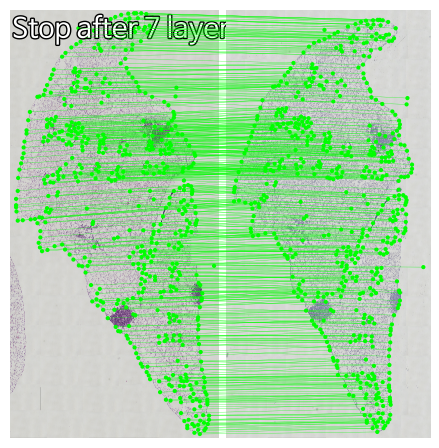

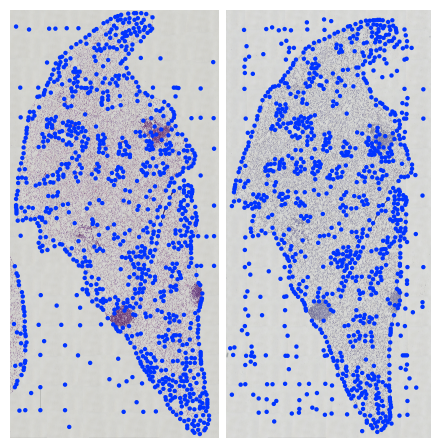

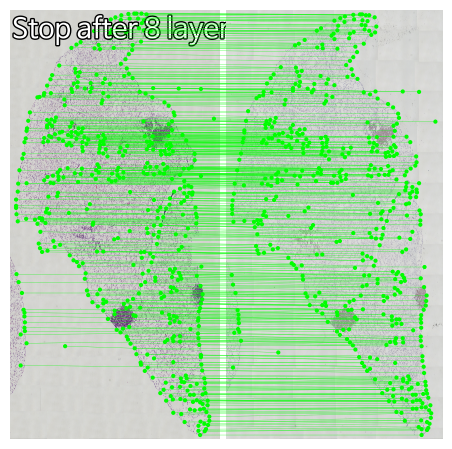

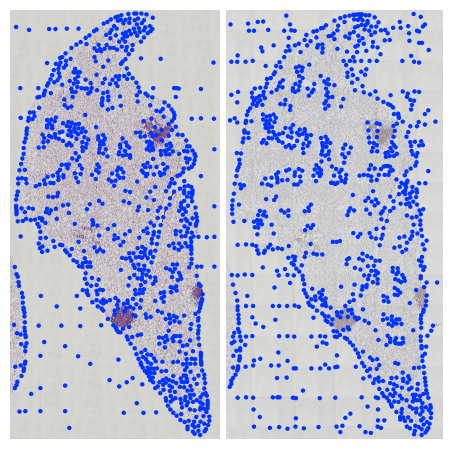

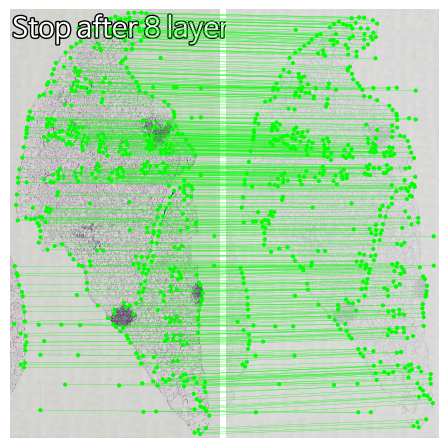

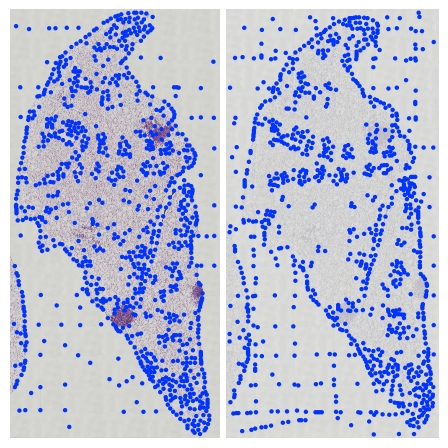

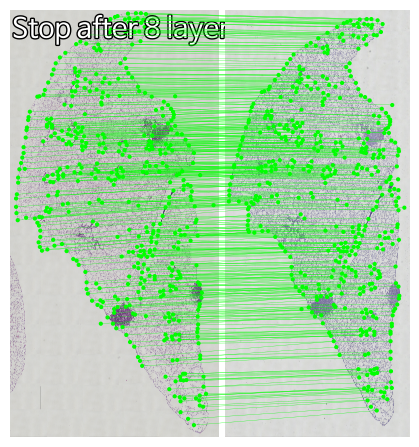

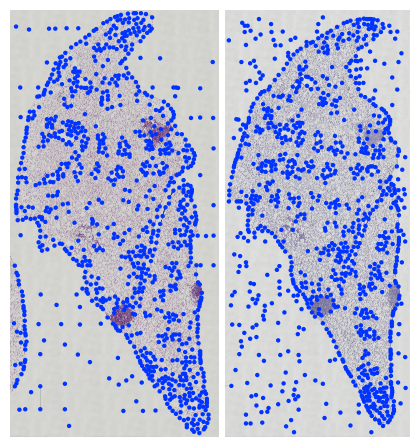

In [6]:
for j in stack3:
    extractor = SuperPoint(max_num_keypoints=j).eval().to(device)  # load the extractor
    for k in stack2:
        for i in stack:
            if k == '100':
                image_0 = "lung-lobes_4/scale-"+k+"pc/29-040-U-35W-Izd2-1-HE.png"
                image_1 = "lung-lobes_4/scale-"+k+"pc/29-040-U-35W-Izd2-"+i+".png"
            else:
                image_0 = "lung-lobes_4/scale-"+k+"pc/29-040-U-35W-Izd2-1-HE.jpg"
                image_1 = "lung-lobes_4/scale-"+k+"pc/29-040-U-35W-Izd2-"+i+".jpg"
            image0 = load_image(image_0)
            image1 = load_image(image_1)

            feats0 = extractor.extract(image0.to(device))
            feats1 = extractor.extract(image1.to(device))
            matches01 = matcher({"image0": feats0, "image1": feats1})
            feats0, feats1, matches01 = [
                rbd(x) for x in [feats0, feats1, matches01]
            ]  # remove batch dimension

            kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
            m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

            axes = viz2d.plot_images([image0, image1])
            viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
            viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
            viz2d.save_plot("./output/lightglue/superpoint/lung-lobes_4/scale-"+k+"pc/matching/keypoints_"+f'{j}'+"_1-HE_"+i+".png", dpi=300)
            kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
            viz2d.plot_images([image0, image1])
            viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
            viz2d.save_plot("./output/lightglue/superpoint/lung-lobes_4/scale-"+k+"pc/visualization/keypoints_"+f'{j}'+"_1-HE_"+i+".png", dpi=300)

In [ ]:
for j in stack3:
    extractor = SuperPoint(max_num_keypoints=j).eval().to(device)  # load the extractor
    for k in stack2:
        for i in stack:
            if k == '100':
                image_0 = "lung-lobes_3/scale-"+k+"pc/29-040-U-35W-Izd1-1-HE.png"
                image_1 = "lung-lobes_3/scale-"+k+"pc/29-040-U-35W-Izd1-"+i+".png"
            else:
                image_0 = "lung-lobes_3/scale-"+k+"pc/29-040-U-35W-Izd1-1-HE.jpg"
                image_1 = "lung-lobes_3/scale-"+k+"pc/29-040-U-35W-Izd1-"+i+".jpg"
            image0 = load_image(image_0)
            image1 = load_image(image_1)

            feats0 = extractor.extract(image0.to(device))
            feats1 = extractor.extract(image1.to(device))
            matches01 = matcher({"image0": feats0, "image1": feats1})
            feats0, feats1, matches01 = [
                rbd(x) for x in [feats0, feats1, matches01]
            ]  # remove batch dimension

            kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
            m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

            axes = viz2d.plot_images([image0, image1])
            viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
            viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
            viz2d.save_plot("./output/lightglue/superpoint/lung-lobes_3/scale-"+k+"pc/matching/keypoints_"+f'{j}'+"_1-HE_"+i+".png", dpi=300)
            plt.close()
            kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
            viz2d.plot_images([image0, image1])
            viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
            viz2d.save_plot("./output/lightglue/superpoint/lung-lobes_3/scale-"+k+"pc/visualization/keypoints_"+f'{j}'+"_1-HE_"+i+".png", dpi=300)
            plt.close()

In [ ]:
for j in stack3:
    extractor = SuperPoint(max_num_keypoints=j).eval().to(device)  # load the extractor
    for k in stack2:
        for i in stack:
            if k == '100':
                image_0 = "lung-lobes_2/scale-"+k+"pc/29-039-U-35W-Izd2-1-HE.png"
                image_1 = "lung-lobes_2/scale-"+k+"pc/29-039-U-35W-Izd2-"+i+".png"
            else:
                image_0 = "lung-lobes_2/scale-"+k+"pc/29-039-U-35W-Izd2-1-HE.jpg"
                image_1 = "lung-lobes_2/scale-"+k+"pc/29-039-U-35W-Izd2-"+i+".jpg"
            image0 = load_image(image_0)
            image1 = load_image(image_1)

            feats0 = extractor.extract(image0.to(device))
            feats1 = extractor.extract(image1.to(device))
            matches01 = matcher({"image0": feats0, "image1": feats1})
            feats0, feats1, matches01 = [
                rbd(x) for x in [feats0, feats1, matches01]
            ]  # remove batch dimension

            kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
            m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

            axes = viz2d.plot_images([image0, image1])
            viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
            viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
            viz2d.save_plot("./output/lightglue/superpoint/lung-lobes_2/scale-"+k+"pc/matching/keypoints_"+f'{j}'+"_1-HE_"+i+".png", dpi=300)
            plt.close()
            kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
            viz2d.plot_images([image0, image1])
            viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
            viz2d.save_plot("./output/lightglue/superpoint/lung-lobes_2/scale-"+k+"pc/visualization/keypoints_"+f'{j}'+"_1-HE_"+i+".png", dpi=300)
            plt.close()

In [ ]:
for j in stack3:
    extractor = SuperPoint(max_num_keypoints=j).eval().to(device)  # load the extractor
    for k in stack2:
        for i in stack:
            if k == '100':
                image_0 = "lung-lobes_1/scale-"+k+"pc/29-039-U-35W-Izd1-1-HE.png"
                image_1 = "lung-lobes_1/scale-"+k+"pc/29-039-U-35W-Izd1-"+i+".png"
            else:
                image_0 = "lung-lobes_1/scale-"+k+"pc/29-039-U-35W-Izd1-1-HE.jpg"
                image_1 = "lung-lobes_1/scale-"+k+"pc/29-039-U-35W-Izd1-"+i+".jpg"
            image0 = load_image(image_0)
            image1 = load_image(image_1)

            feats0 = extractor.extract(image0.to(device))
            feats1 = extractor.extract(image1.to(device))
            matches01 = matcher({"image0": feats0, "image1": feats1})
            feats0, feats1, matches01 = [
                rbd(x) for x in [feats0, feats1, matches01]
            ]  # remove batch dimension

            kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
            m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

            axes = viz2d.plot_images([image0, image1])
            viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
            viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
            viz2d.save_plot("./output/lightglue/superpoint/lung-lobes_1/scale-"+k+"pc/matching/keypoints_"+f'{j}'+"_1-HE_"+i+".png", dpi=300)
            kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
            viz2d.plot_images([image0, image1])
            viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
            viz2d.save_plot("./output/lightglue/superpoint/lung-lobes_1/scale-"+k+"pc/visualization/keypoints_"+f'{j}'+"_1-HE_"+i+".png", dpi=300)

In [7]:
torch.__version__

'2.4.0+cu121'

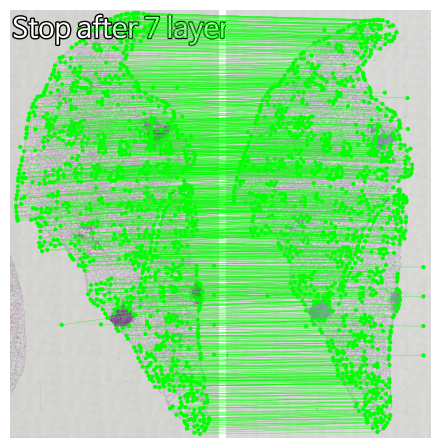

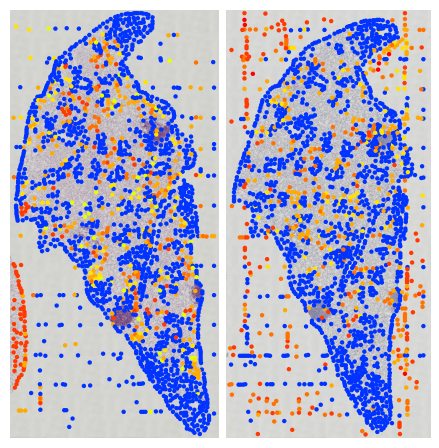

In [ ]:
image0 = load_image("lung-lobes_4/scale-25pc/29-040-U-35W-Izd2-1-HE.jpg")
image1 = load_image("lung-lobes_4/scale-25pc/29-040-U-35W-Izd2-2-cd31.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
viz2d.save_plot("matching.png", dpi=300)
kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
viz2d.save_plot("visualization.png", dpi=300)

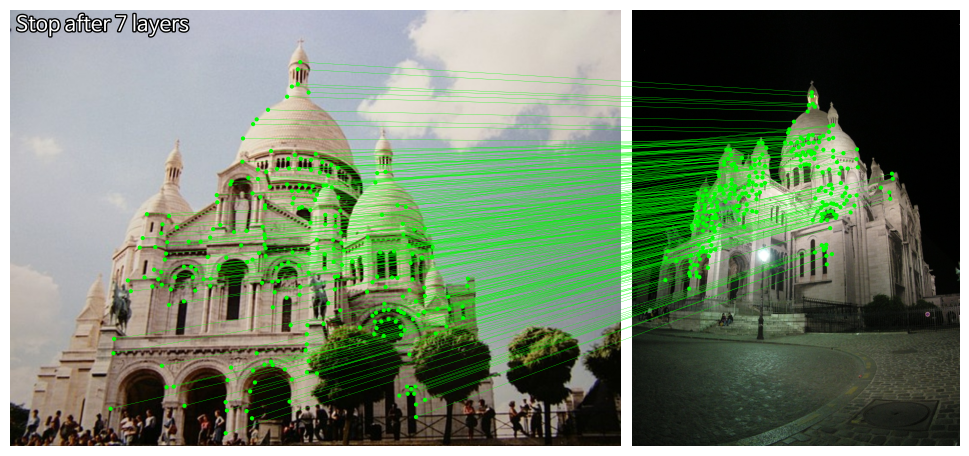

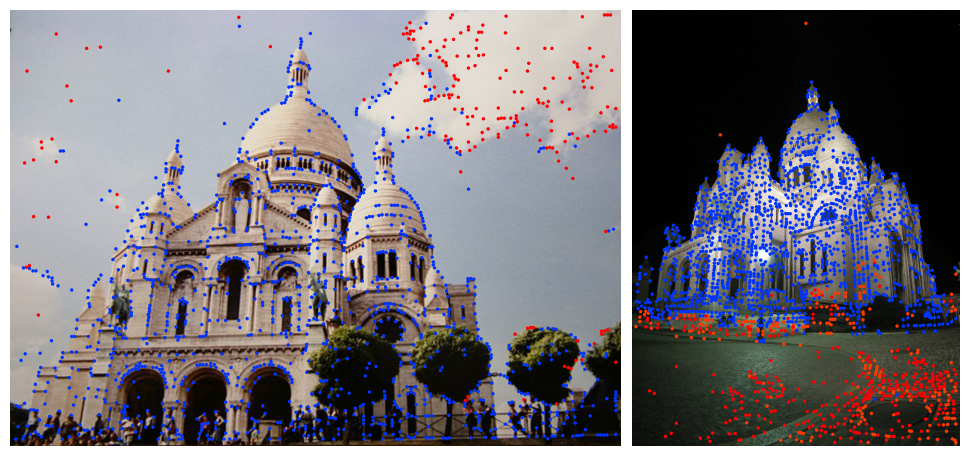

In [4]:
image0 = load_image(images / "sacre_coeur1.jpg")
image1 = load_image(images / "sacre_coeur2.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)